# Capstone Project: Toronto BikeShare
## Part 4: Network Analysis
---
Jason Ho<br>
December 13th, 2020

In this notebook we will be completing a network analysis on the cleaned dataset to see if we can gain any insights into the relationship between each station in the network created by bikeshare users.

Please load the environment created specifically for this capstone project before moving ahead.

Resources that I had consulted rearding various code used below are follows:<br>
https://python-graph-gallery.com/<br>
https://stackoverflow.com/<br>

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools

# Network packages
import osmnx as ox
import networkx as nx

# Timer
from tqdm import tqdm
import time

## Table of Contents
[Data Dictionary](#Data-Dictionary)<br>

[Data Cleaning](#Data-Cleaning)<br>

[Network Analysis](#Data-Wrangling)<br>
- [Trip Datasets](#Trip-Datasets)<br>
- [Station Information Dataset](#Station-Information-Dataset)
[Summary & Next Steps](#Summary-&-Next-Steps)<br>
[Mapping Toronto Using OSMX](#Mapping-Toronto-Using-OSMX)<br>


## Data Dictionary

- `Trip Id`: Unique ID code for individual trip taken.
- `Subscription Id`: Unique ID code for the individual member, this can be used to track Annual Member usage
- `Bike Id`: Unique ID for the individual bike used
- `Start Time`: Trip start time
- `Start Station Id`: Unique ID code for the start station
- `Start Station Name`: Name of the start station
- `Start Station Latitude`: Latitude coordinates ofthe  start station
- `Start Station Longitude`: Longitude coordinates of the start station
- `Start Station Elevation`: Elevation in meters for the start station
- `Start Station Capacity`: Bike dock capacity for the start station
- `Start Station Accepts Credit Card`: Binary classifier for whether the station accepts credit card payments
- `Start Station FSA`: Forward Sortation Area for where the start station is located
- `End Time`: Trip end time.
- `End Station Id`: Unique ID code for the end station.
- `End Station Name`: Name of the end station.
- `End Station Latitude`: Latitude coordinates of the end station
- `End Station Longitude`: Longitude coordinates of the end station
- `End Station Elevation`: Elevation in meters for the end station
- `End Station Capacity`: Bike dock capacity for the end station
- `End Station Accepts Credit Card`: Binary classifier for whether the end station accepts credit card payments
- `End Station FSA`: Forward Sortation Area for where the end station is located
- `Trip Duration Minutes`: Duration of the trip in minutes.
- `Is Member`: Binary classifier for whether the user is an annual member
- `Temp (°C)`: Temperature in Celsius at the start of the trip
- `Rel Hum (%)`: Relative Humdity at the start of the trip
- `Wind Spd (km/h)`: Wind speed in km/h at the start of the trip

## Data Cleaning

Back to [Table of Contents](#Table-of-Contents).<br>

In [2]:
# Load Datasets
trip_df = pd.read_csv('data/master_df.csv')
network_df = pd.read_csv('data/station_info_clean.csv')

In [3]:
# View Datasets
display(trip_df.head())
display(network_df.head())

,Unnamed: 0,Trip Id,Start Time,Start Station Id,Start Station Name,Start Station Latitude,Start Station Longitude,Start Station Elevation,Start Station Capacity,Start Station Accepts Credit Card,...,End Station Longitude,End Station Elevation,End Station Capacity,End Station Accepts Credit Card,End Station FSA,Trip Duration Minutes,Is Member,Temp (°C),Rel Hum (%),Wind Spd (km/h)
0,0,712382,2017-01-01 00:00:00,7051,Wellesley St E / Yonge St Green P,43.654879,-79.375091,90.0,19.0,1.0,...,-79.379903,118.0,19.0,1.0,M5B,4,1,1.5,69.0,39.0
1,1,712383,2017-01-01 00:00:00,7143,Kendal Ave / Bernard Ave,43.671513,-79.408317,120.0,15.0,1.0,...,-79.411667,118.0,23.0,1.0,M5R,5,1,1.5,69.0,39.0
2,2,712384,2017-01-01 00:05:00,7113,Parliament St / Aberdeen Ave,43.665278,-79.368333,103.0,15.0,1.0,...,-79.409167,108.0,19.0,1.0,M6G,23,1,1.5,69.0,39.0
3,3,712385,2017-01-01 00:07:00,7077,College Park South,43.659777,-79.382767,107.0,19.0,1.0,...,-79.395003,88.0,19.0,1.0,M5V,14,1,1.5,69.0,39.0
4,4,712386,2017-01-01 00:08:00,7079,McGill St / Church St,43.660694,-79.379052,104.0,19.0,1.0,...,-79.389165,106.0,25.0,1.0,M5G,5,1,1.5,69.0,39.0


,Unnamed: 0,station_id,name,latitude,longitude,elevation,capacity,fsa,regular_config,creditcard_payment
0,0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,77,35,M5V,0,1
1,1,7001,Lower Jarvis St / The Esplanade,43.647830,-79.370698,83,15,M5E,0,1
2,2,7002,St. George St / Bloor St W,43.667333,-79.399429,120,19,M5S,0,1
3,3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,118,15,M5S,0,1
4,4,7004,University Ave / Elm St,43.656518,-79.389099,106,11,M5G,0,1


In [4]:
# Drop duplicate index column
trip_df.drop(['Unnamed: 0'], axis=1, inplace=True)
network_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
# Check for duplicates
print(f"Duplicates found in trip dataframe: {trip_df.duplicated().sum()}")
print('\n----------------------------------------\n')
print(f"Duplicates found in network dataframe: {network_df.duplicated().sum()}")

Duplicates found in trip dataframe: 0

----------------------------------------

Duplicates found in network dataframe: 0


In [6]:
# Check for null values
print(f'Total Number of Null values in trip dataframe:\n\n{trip_df.isna().sum()}')
print('\n----------------------------------------\n')
print(f'Total Percentage of Null values in trip dataframe:\n\n{trip_df.isna().mean()*100}')
print('\n----------------------------------------\n')
print(f'Total Number of Null values in network dataframe:\n\n{network_df.isna().sum()}')
print('\n----------------------------------------\n')
print(f'Total Percentage of Null values in network dataframe:\n\n{network_df.isna().mean()*100}')

Total Number of Null values in trip dataframe:

Trip Id                              0
Start Time                           0
Start Station Id                     0
Start Station Name                   0
Start Station Latitude               0
Start Station Longitude              0
Start Station Elevation              0
Start Station Capacity               0
Start Station Accepts Credit Card    0
Start Station FSA                    0
End Time                             0
End Station Id                       0
End Station Name                     0
End Station Latitude                 0
End Station Longitude                0
End Station Elevation                0
End Station Capacity                 0
End Station Accepts Credit Card      0
End Station FSA                      0
Trip Duration Minutes                0
Is Member                            0
Temp (°C)                            0
Rel Hum (%)                          0
Wind Spd (km/h)                      0
dtype: int64

--

Now that we finished checking if the dataset is clean we can move on to complete a network analysis on the datasets.

## Network Analysis

Back to [Table of Contents](#Table-of-Contents).<br>

First we will need to create a list of nodes and a list of edges for us to graph the network out. I will be including the longitude and latitude coordinates for the nodes so that when plotted it will resemble the City of Toronto rather than amorphous blob.

### Node List

In [7]:
# Check column headers for network dataframe
network_df.columns

Index(['station_id', 'name', 'latitude', 'longitude', 'elevation', 'capacity',
       'fsa', 'regular_config', 'creditcard_payment'],
      dtype='object')

In [8]:
# Create a node list with coordinates
node_list = list(zip(network_df['station_id'], 
                     network_df['longitude'], 
                     network_df['latitude']))

### Edge List

In [9]:
# Create a list of tuples for the edges in the network
edge_list = list(zip(trip_df['Start Station Id'], trip_df['End Station Id']))

In [10]:
# Check number of edge connections
len(edge_list)

8446163

There are over 8.4 million edges in this edge list and it will take quite awhile to draw this out. Therefore I will create a separate dataframe and see if I can add weight to the edges in order decrease the amount of duplicate edges drawn on the graph while preseving information regarding how well travelled each edge were.

In [11]:
# Create a separate df with the number of similar trip count in preparation to form another tuple list
edge_df = (trip_df.groupby(['Start Station Id', 'End Station Id'])
           .apply(lambda x : x['End Station Id'].isin(x['End Station Id']).astype(int).sum())
           .reset_index(name='Trip Count')
          )

In [12]:
# Check dataframe
edge_df.head()

,Start Station Id,End Station Id,Trip Count
0,7000,7000,3141
1,7000,7001,271
2,7000,7002,62
3,7000,7003,70
4,7000,7004,247


In [13]:
# Remove values where Start Station Id and End Station ID are the same as they will not create any edges
edge_df = edge_df[edge_df['Start Station Id'] != edge_df['End Station Id']]

In [14]:
# Sort rows by trip count
edge_df.sort_values(by=['Trip Count'], ascending=False)

,Start Station Id,End Station Id,Trip Count
26642,7059,7033,6204
80820,7203,7076,5736
34078,7076,7203,5012
127368,7344,7354,4394
69912,7171,7242,3902
...,...,...,...
26819,7059,7229,1
143002,7391,7380,1
26813,7059,7223,1
26792,7059,7194,1


Looks like we were able to condense the ~8.5 million edges down to less than 200K. Let's take a closer look into the distribution of the trips that formed these edges.

In [15]:
# Check stats on Trip Count
edge_df['Trip Count'].describe()

count    193494.000000
mean         41.756344
std         109.797831
min           1.000000
25%           3.000000
50%           9.000000
75%          36.000000
max        6204.000000
Name: Trip Count, dtype: float64

It looks like a majority of these edge connections happen less than 9 times, and 75% of connections only happen 36 times or less and the average number of edge connection at ~42. Since I am only interested in strongly connected stations so I will cutoff all edges where the Trip Count value is less than the rounded mean.

In [16]:
# Remove any weak connecting edges
edge_df = edge_df[edge_df['Trip Count'] >= 42]

In [17]:
# Final check
display(edge_df.head())
print(len(edge_df))

,Start Station Id,End Station Id,Trip Count
1,7000,7001,271
2,7000,7002,62
3,7000,7003,70
4,7000,7004,247
5,7000,7005,920


44250


In [18]:
# Check stats on Trip Count
edge_df['Trip Count'].describe()

count    44250.000000
mean       150.169401
std        192.686606
min         42.000000
25%         60.000000
50%         92.000000
75%        166.000000
max       6204.000000
Name: Trip Count, dtype: float64

Since it is not a normal distribution, when applying a colour scale to this weight, it would be high skewed. Therefore I will create a new column and apply a base10 logirithmic scale to it so when it is graphed with the color scale we can see the distribution better.

In [19]:
# Log scale the weight of edges
edge_df['Trip Count Scaled'] = np.log10(edge_df['Trip Count'])

In [20]:
display(edge_df.head())

,Start Station Id,End Station Id,Trip Count,Trip Count Scaled
1,7000,7001,271,2.432969
2,7000,7002,62,1.792392
3,7000,7003,70,1.845098
4,7000,7004,247,2.392697
5,7000,7005,920,2.963788


In [21]:
# Check stats on Trip Count Scaled
edge_df['Trip Count Scaled'].describe()

count    44250.000000
mean         2.031438
std          0.314877
min          1.623249
25%          1.778151
50%          1.963788
75%          2.220108
max          3.792672
Name: Trip Count Scaled, dtype: float64

The scaling seems to have worked well. Now I will transform the dataframe into a tuple list then produce a directed graph and an undirected graph to compare the results.

In [22]:
# Create a list of tuples for the edges in the network
edge_list2 = list(zip(edge_df['Start Station Id'], 
                      edge_df['End Station Id'], 
                      edge_df['Trip Count Scaled']))

In [23]:
G2=nx.DiGraph()

# Create nodes with position coordinates
for name, lon, lat in node_list:
    G2.add_node(name, pos=(lon, lat))

# Add weighted edges
G2.add_weighted_edges_from(edge_list2)

In [24]:
G3=nx.Graph()

# Create nodes with position coordinates
for name, lon, lat in node_list:
    G3.add_node(name, pos=(lon, lat))

# Add weighted edges
G3.add_weighted_edges_from(edge_list2)

In [25]:
# Number of nodes
print(f'Total Number of Nodes: {len(G2)}\n')

# Number of edges
print(f'Total Number of Edges: {len(G2.edges())}\n')
print('------------------------------------------------------------\n')
# Average cluster coefficient
print (f'Average cluster coefficient for directed graph: {nx.average_clustering(G2)}\n')
print (f'Average cluster coefficient for undirected graph: {nx.average_clustering(G3)}')

Total Number of Nodes: 607

Total Number of Edges: 44250

------------------------------------------------------------

Average cluster coefficient for directed graph: 0.5488740860614361

Average cluster coefficient for undirected graph: 0.5729673682473087


The average cluster coefficient is also known as the global clustering coefficient that  that describes the network's overall tendency towards being clustered, we can take the average of the local clustering coefficient across every node in the network.

We can see that the undirected graph has a slightly higher tendency for being clustered but since trips are directed in nature, 0.54 for directed graph would be a more accurate measure for our network.

In [26]:
# Create separate tuple lists to aide in denoting edge colorscale
edges = tuple(zip(edge_df['Start Station Id'], 
            edge_df['End Station Id']))
weights = tuple(edge_df['Trip Count Scaled'])

In [27]:
# Draw directed network
fig=plt.figure(figsize=(16,10))
nx.draw(G2, nx.get_node_attributes(G2, 'pos'), 
        with_labels=False, 
        node_size=10,
        node_color='#1b444f',
        edgelist=edges, 
        edge_color=weights, 
        width=1, 
        edge_cmap=plt.get_cmap('viridis'))

fig.set_facecolor('#062b36')
plt.show()

KeyboardInterrupt: 

In [ ]:
# Draw undirected network
fig=plt.figure(figsize=(32,20))
nx.draw(G3, nx.get_node_attributes(G3, 'pos'), 
        with_labels=False, 
        node_size=10,
        node_color='#1b444f',
        edgelist=edges, 
        edge_color=weights, 
        width=1, 
        edge_cmap=plt.get_cmap('viridis'))

# fig.set_facecolor('#062b36')
plt.show()

In both undirected and directed graphs we see that the western portion of the harbourfront has the majority of travel occurring in the network with some higher than normal travel north/south in one specific corridor which may be the Don Valley Trail.

We also see some weakly (un)connected stations that had less than 50 trips in my dataset of 4 years worht of trip data. These stations may need to be decommissioned or have a better targeted marketing campaign for these areas.

Next we will take a look into the centrality metrics we can derive from analysing the network.

### Centrality Metrics

#### Degree Centrality

First centrality measure we can use is _Degree Centrality_ which is a basic measure to see which node has the most neighbors.

In [76]:
# Top 10 stations by degree centrality in directed graph
deg_dict = {k: round(v,10) for k,v in sorted(list(G2.degree), key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(deg_dict.items(), 10)))

{7076: 554, 7006: 543, 7049: 532, 7016: 527, 7022: 525, 7027: 505, 7102: 500, 7100: 492, 7038: 488, 7017: 486}


In [77]:
# Top 10 stations by degree centrality in undirected graph
deg_dict2 = {k: round(v,10) for k,v in sorted(list(G3.degree), key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(deg_dict2.items(), 10)))

{7076: 294, 7006: 290, 7016: 286, 7049: 282, 7022: 278, 7102: 275, 7030: 270, 7017: 267, 7027: 267, 7100: 266}


In [78]:
trip_df.loc[trip_df['Start Station Id']==7076].head(1)

,Trip Id,Start Time,Start Station Id,Start Station Name,Start Station Latitude,Start Station Longitude,Start Station Elevation,Start Station Capacity,Start Station Accepts Credit Card,Start Station FSA,...,End Station Longitude,End Station Elevation,End Station Capacity,End Station Accepts Credit Card,End Station FSA,Trip Duration Minutes,Is Member,Temp (°C),Rel Hum (%),Wind Spd (km/h)
175,712560,2017-01-01 16:28:00,7076,York St / Queens Quay W,43.640132,-79.380464,74.0,27.0,1.0,M5J,...,-79.279682,132.0,23.0,1.0,M1N,5,1,2.8,57.0,21.0


It appears the station with the most connected edges in both the directed graph and undirected graph is 7076 which is 'York St / Queens Quay W'

#### Closeness Centrality

Next metric is _Closeness Centrality_ which measures a node's average shortest path length to each of the other nodes. A node with a high closeness score in this context would have a lot of nearby bike stations where users commonly travel to and from.

In [73]:
# To sort the dictionary by closeness centrality and round its values
cc_dict = {k: round(v,10) for k,v in sorted(nx.closeness_centrality(G2).items(), key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(cc_dict.items(), 10)))

{7076: 0.5692062627, 7016: 0.555907051, 7006: 0.5507597635, 7049: 0.5457069216, 7022: 0.5432151092, 7203: 0.5364785069, 7102: 0.5352715812, 7043: 0.5346701524, 7027: 0.5340700737, 7168: 0.5304976986}


In [74]:
# To sort the dictionary by closeness centrality and round its values
cc_dict2 = {k: round(v,10) for k,v in sorted(nx.closeness_centrality(G3).items(), key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(cc_dict2.items(), 10)))

{7076: 0.5795120005, 7016: 0.5681751719, 7006: 0.5649247419, 7049: 0.5585341905, 7102: 0.5541461554, 7022: 0.5522866045, 7030: 0.5522866045, 7043: 0.5473882754, 7100: 0.5473882754, 7027: 0.5455737286}


It appears the station with the highest closeness centrality in both the directed graph and undirected graph is also 7076 which is 'York St / Queens Quay W'.

Now lets take a look at the closeness centrality of the whole network.

KeyboardInterrupt: 

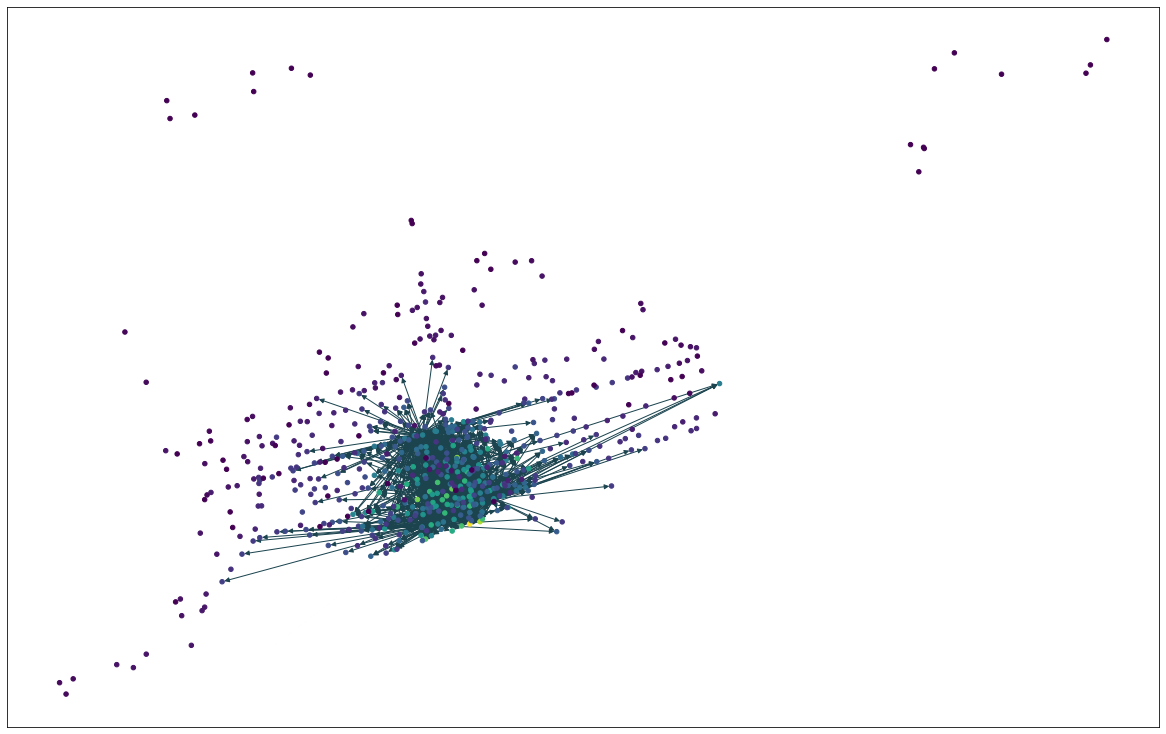

In [28]:
# Color weighted nodes
cc1 = np.exp([c[1]*10 for c in nx.closeness_centrality(G2).items()])

fig=plt.figure(figsize=(16,10))
nx.draw(G2, nx.get_node_attributes(G2, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=cc1,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
plt.savefig('cc.png')
plt.show()

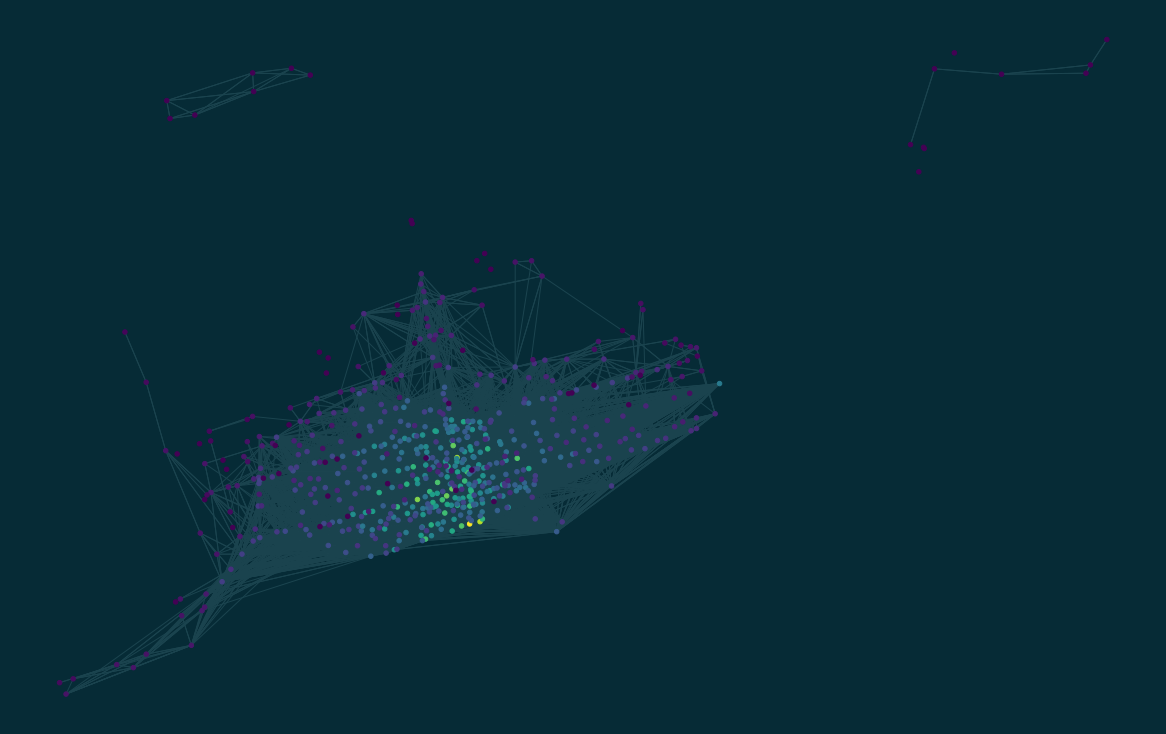

In [35]:
# Color weighted nodes
cc2 = np.exp([c[1]*10 for c in nx.closeness_centrality(G3).items()])

fig=plt.figure(figsize=(16, 10))
nx.draw(G3, nx.get_node_attributes(G3, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=cc2,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
plt.savefig('cc2.png')
plt.show()

In both undirected graph and idrected graph we see that al majority of the centrally located station have high closeness centrality then there seem to be a moderate outlier on the east end that may suggest that is a good area of expansion.

#### Betweenness Centrality

Next metric is called _Betweenness Centrality_ which is similar to closeness centrality but tells us how many of the network's shortest paths does a node lie on. Nodes with high betweenness centrality in this context tells us which stations are important for users to use to check in to avoid late fees and continue their trip. More tweaking of data may be required to gain a better accurate measure by grouping trips by subscription id or bike id to get a more accruate betweenness measure.

In [43]:
# To sort the dictionary by betweenness centrality and round its values
bc_dict = {k:round(v,5) for k,v in sorted(nx.betweenness_centrality(G2).items(), key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(bc_dict.items(), 10)))

{7288: 0.02052, 7076: 0.01947, 7100: 0.01784, 7454: 0.01539, 7289: 0.01505, 7016: 0.01382, 7006: 0.01335, 7083: 0.01293, 7126: 0.0128, 7207: 0.01274}


In [44]:
# To sort the dictionary by betweenness centrality and round its values
bc_dict2 = {k:round(v,5) for k,v in sorted(nx.betweenness_centrality(G3).items(), key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(bc_dict2.items(), 10)))

{7288: 0.02112, 7076: 0.01761, 7454: 0.01707, 7289: 0.01621, 7126: 0.01454, 7100: 0.01387, 7016: 0.01314, 7104: 0.01295, 7326: 0.01148, 7034: 0.01119}


In [79]:
trip_df.loc[trip_df['Start Station Id']==7288].head(1)

,Trip Id,Start Time,Start Station Id,Start Station Name,Start Station Latitude,Start Station Longitude,Start Station Elevation,Start Station Capacity,Start Station Accepts Credit Card,Start Station FSA,...,End Station Longitude,End Station Elevation,End Station Capacity,End Station Accepts Credit Card,End Station FSA,Trip Duration Minutes,Is Member,Temp (°C),Rel Hum (%),Wind Spd (km/h)
1495490,2387877,2018-01-04 16:28:00,7288,Humber Bay Shores Park West,43.622443,-79.480284,76.0,31.0,1.0,M8V,...,-79.467763,75.0,19.0,1.0,M6S,6,1,-11.5,56.0,22.0


It looks like node with the highest betweenness centraility is station 7288 or Humber Bay Shores Park West in the west end. This station may need to be monitored more closely for capacity level to make sure users are able to connect to/from.

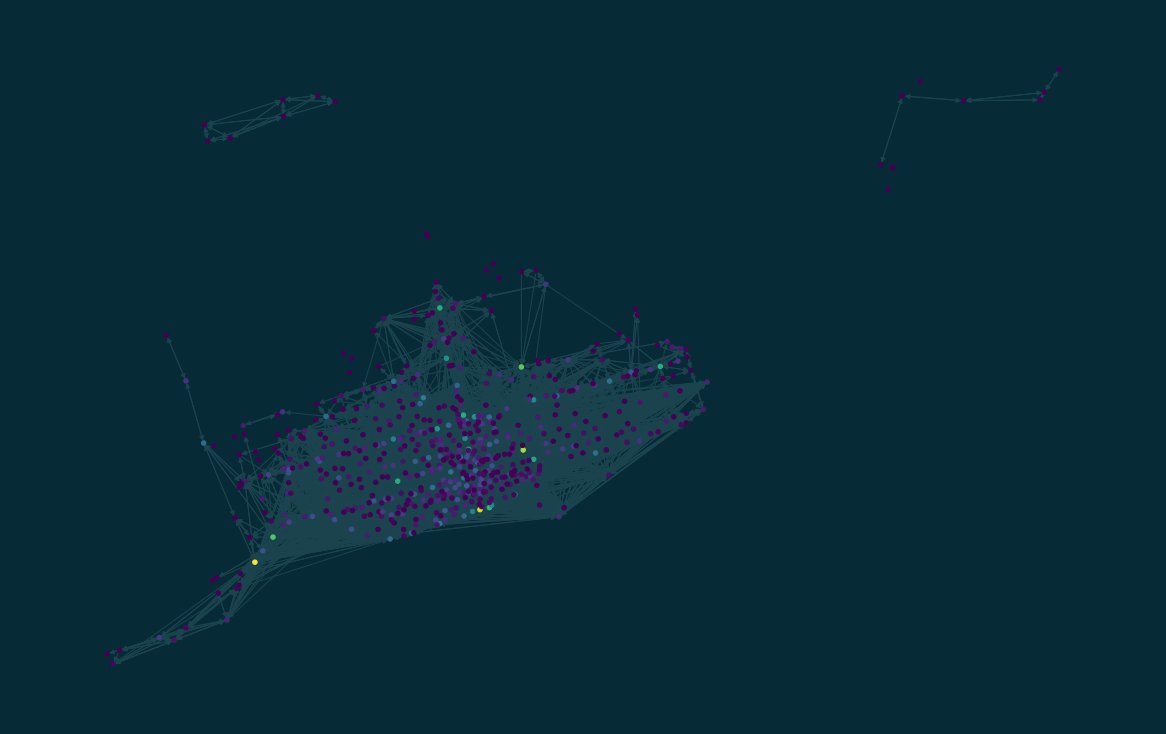

In [45]:
# Color weighted nodes
bc = np.exp([c[1] for c in nx.betweenness_centrality(G2).items()])

fig=plt.figure(figsize=(16,10))
nx.draw(G2, nx.get_node_attributes(G2, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=bc,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
# plt.savefig('edges.png')
plt.show()

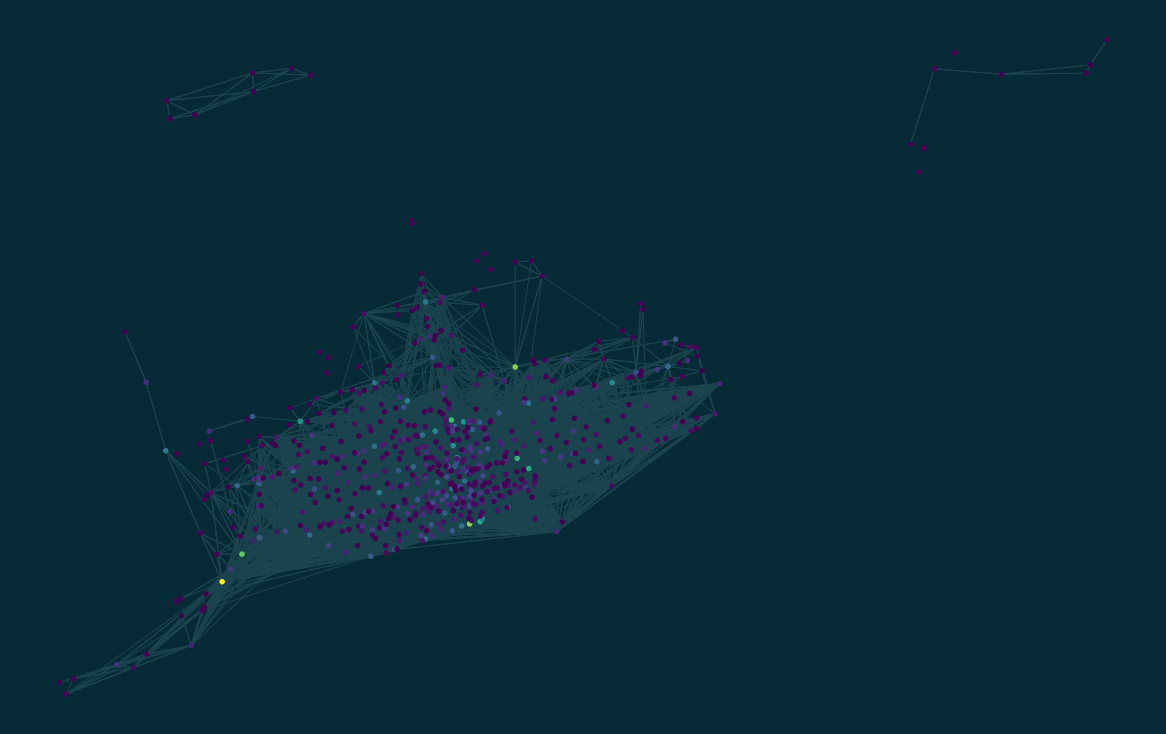

In [46]:
# Color weighted nodes
bc2 = np.exp([c[1] for c in nx.betweenness_centrality(G3).items()])

fig=plt.figure(figsize=(16,10))
nx.draw(G3, nx.get_node_attributes(G3, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=bc2,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
# plt.savefig('edges.png')
plt.show()

Both graphs show the same nodes with high betweenness centrality though this time the directed graph has higher values. Statiions with high betweenness also seem to be around the outskirts of the network more so the centrally clustered.

#### Clustering Coefficient

Next metric is **local**_clustering coefficient_. It gives us the proportion of its connection are connect to another in a local cluster.

In [47]:
clust_dict = {k:round(v,3) for k,v in sorted(nx.clustering(G2).items(), key=lambda item: item[1], reverse=True)}

dict(itertools.islice(clust_dict.items(), 10))

{7413: 1.0,
 7447: 1.0,
 7460: 1.0,
 7501: 1.0,
 7527: 1.0,
 7538: 1.0,
 7540: 1.0,
 7555: 1.0,
 7556: 1.0,
 7573: 1.0}

In [80]:
clust_dict = {k:round(v,3) for k,v in sorted(nx.clustering(G3).items(), key=lambda item: item[1], reverse=True)}

dict(itertools.islice(clust_dict.items(), 10))

{7301: 1.0,
 7392: 1.0,
 7413: 1.0,
 7447: 1.0,
 7460: 1.0,
 7501: 1.0,
 7527: 1.0,
 7538: 1.0,
 7540: 1.0,
 7552: 1.0}

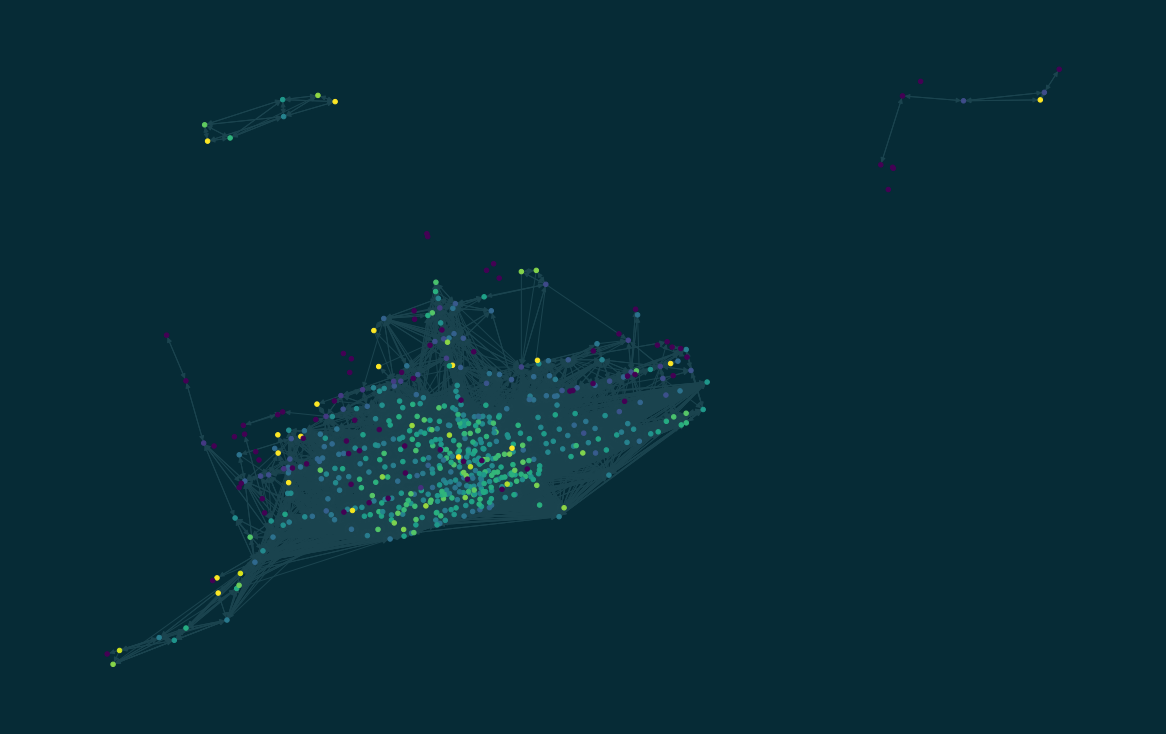

In [87]:
# Color weighted nodes
clust = np.exp([c[1] for c in nx.clustering(G2).items()])

fig=plt.figure(figsize=(16,10))
nx.draw(G2, nx.get_node_attributes(G2, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=clust,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
# plt.savefig('edges.png')
plt.show()

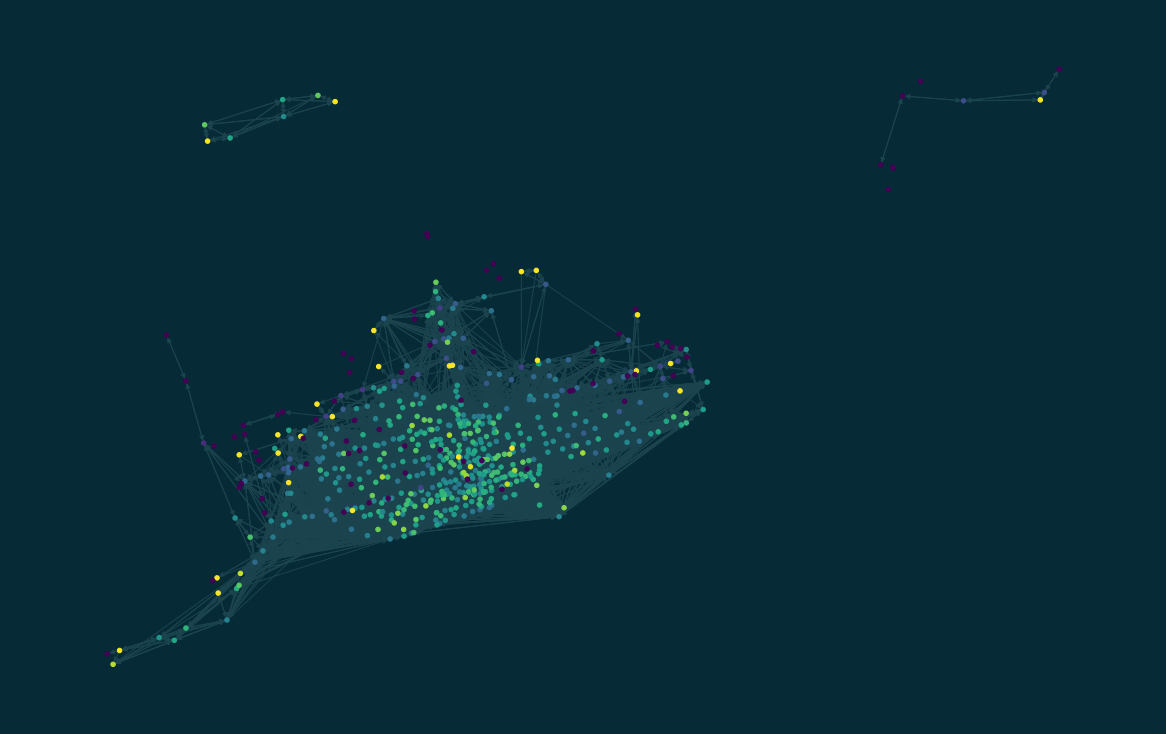

In [88]:
# Color weighted nodes
clust2 = np.exp([c[1] for c in nx.clustering(G3).items()])

fig=plt.figure(figsize=(16,10))
nx.draw(G2, nx.get_node_attributes(G2, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=clust2,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
# plt.savefig('edges.png')
plt.show()

It appears a majority of stations are highly clustered in the network, and we saw previously that the global clustering coefficient for both the undirected and directed graphs are ~0.54. 

This graph will show stations that are not as well connected to network i.e. not as well used. We can see there are stations that are speckled around the main cluster network and will need further analysis to see if these stations are still active and if they are we may need to take them remove them as they are not as frequented as others in the same area.

#### PageRank Algorithm

_Google's PageRank Centrality_ measure that only works on directed graphs where it ranks the nodes based on the weights of incoming links, in this case it is the number of incoming trips to the station. It was originally designed as an algorithm to rank web pages.

In [50]:
# To sort the dictionary by betweenness centrality and round its values
pagerank_dict = {k:round(v,3) for k,v in sorted(nx.pagerank(G2).items(), key=lambda item: item[1], reverse=True)}

dict(itertools.islice(pagerank_dict.items(), 10))

{7076: 0.006,
 7016: 0.006,
 7049: 0.005,
 7022: 0.005,
 7006: 0.005,
 7100: 0.005,
 7033: 0.005,
 7203: 0.005,
 7168: 0.005,
 7102: 0.005}

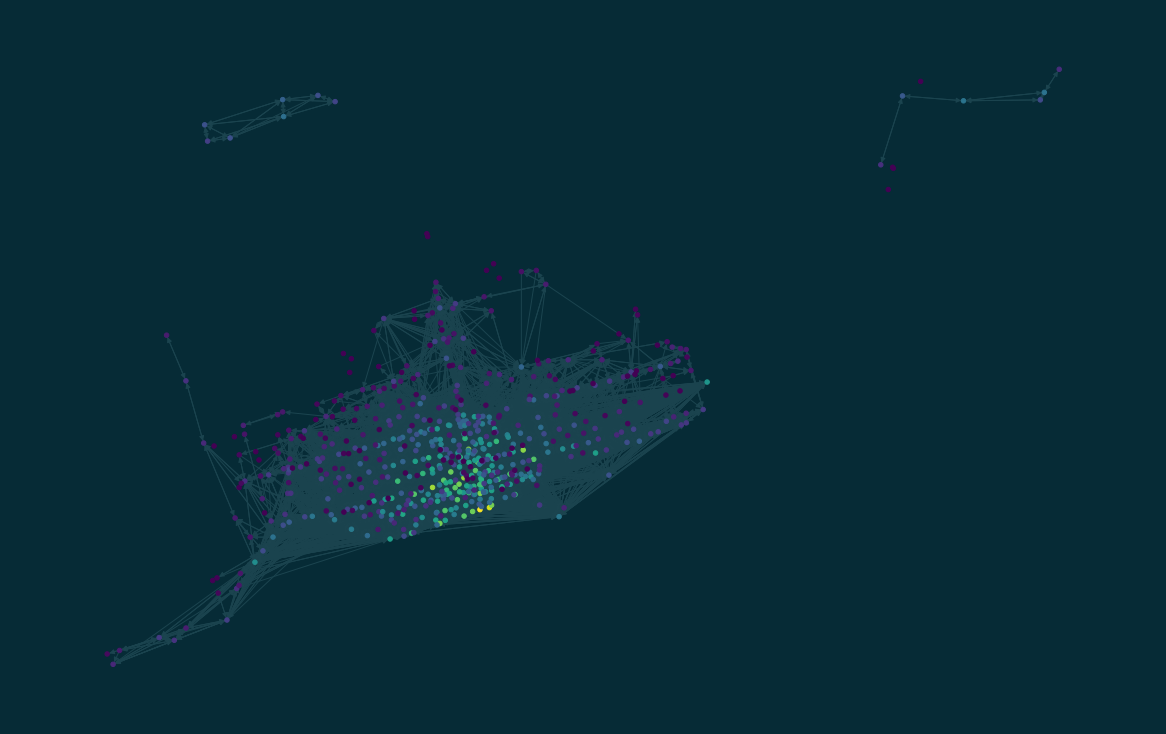

In [86]:
# Color weighted nodes
pr = np.exp([c[1]*10 for c in nx.pagerank(G2).items()])

fig=plt.figure(figsize=(16,10))
nx.draw(G2, nx.get_node_attributes(G2, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=pr,
        cmap=plt.get_cmap('viridis'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
# plt.savefig('edges.png')
plt.show()

Here we can see that a majority of station that have the highest page rank are centrally located station inside their respective physical cluster with the highest page rankings downtown and along the habourfront.

In [51]:
from networkx.algorithms.community import greedy_modularity_communities
# Run algorithm to find number of clusters
clusters = greedy_modularity_communities(G3)

print(f'The Toronto BikeShare network has {len(clusters)} clusters.')

The Toronto BikeShare network has 54 clusters.


In [53]:
# List the 54 clusters
list(greedy_modularity_communities(G3))

[frozenset({7000,
            7001,
            7002,
            7003,
            7004,
            7005,
            7006,
            7007,
            7008,
            7009,
            7010,
            7011,
            7012,
            7013,
            7014,
            7015,
            7016,
            7017,
            7018,
            7019,
            7020,
            7021,
            7022,
            7023,
            7024,
            7025,
            7026,
            7027,
            7028,
            7029,
            7030,
            7031,
            7032,
            7033,
            7034,
            7035,
            7036,
            7037,
            7038,
            7039,
            7040,
            7041,
            7042,
            7043,
            7044,
            7045,
            7046,
            7047,
            7048,
            7049,
            7050,
            7051,
            7052,
            7053,
            7054,
          

It looks like the only 8 of the clusters actually have more than 1 node in the cluster, therefore I will create a color code system for these 8 clusters then all others will be coded a neutral color.

In [52]:
# Code lifted from the lecture notebook

def set_cluster_number(G, cluster_list):
    '''
    Takes a graph G and a list of clusters and assigns an attribute
    to each node in G containing its cluster number.
    
    '''
    for i, cluster in enumerate(cluster_list):
        
        for node in cluster:
            G.nodes[node]['cluster'] = i+1

def get_node_color(node):
    '''
    Chooses a colour for a node based on its cluster number.
    (Assumes that there are 4 or fewer clusters, for convenience.)
    '''
    if node['cluster'] == 1:
        color = '#e41a1c'
    elif node['cluster'] == 2:
        color = '#377eb8'
    elif node['cluster'] == 3:
        color = '#4daf4a'
    elif node['cluster'] == 4:
        color = '#984ea3'
    elif node['cluster'] == 5:
        color = '#ff7f00'
    elif node['cluster'] == 6:
        color = '#ffff33'
    elif node['cluster'] == 7:
        color = '#a65628'
    elif node['cluster'] == 8:
        color = '#f781bf'
    else:
        color = '#0a3642'
    return color

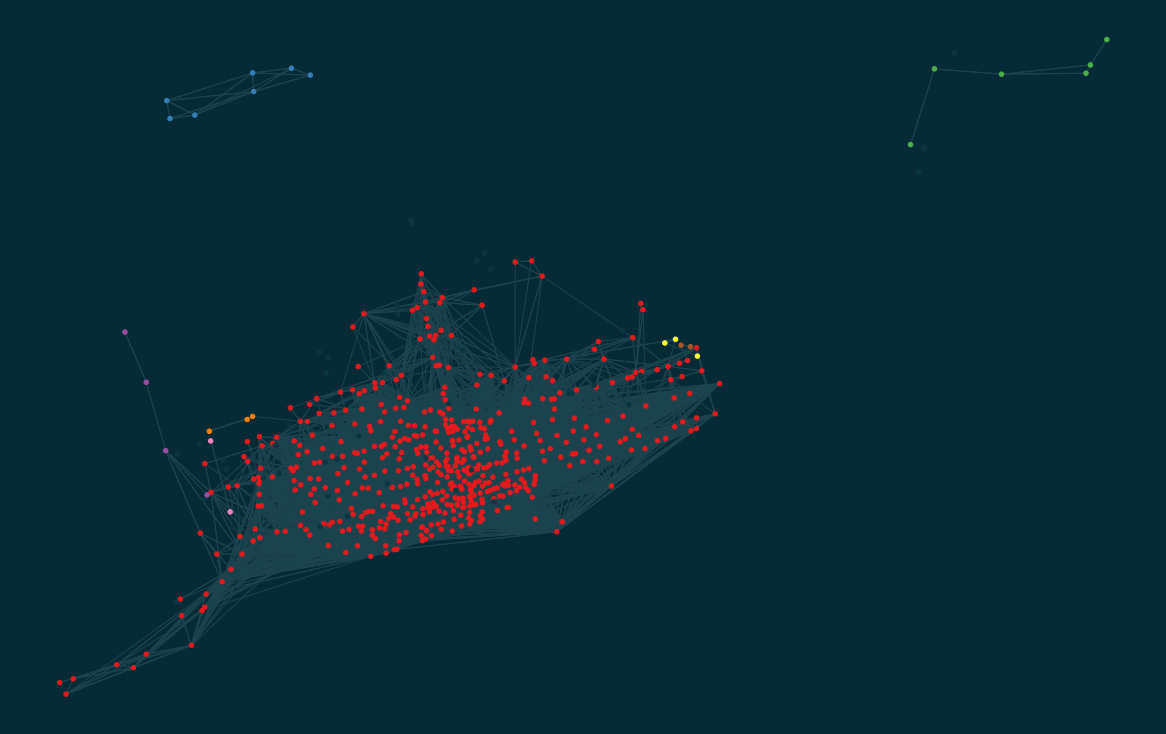

In [54]:
# Assign each node its cluster number
set_cluster_number(G3, clusters)

fig=plt.figure(figsize=(16,10))
nx.draw(G3, nx.get_node_attributes(G3, 'pos'), 
        with_labels=False,
        node_size=20,
        node_color=[get_node_color(G3.nodes[n]) for n in G3.nodes],
        cmap=plt.get_cmap('viridis_r'),
        edgelist=edges, 
        edge_color='#1b444f', 
        width=1)

fig.set_facecolor('#062b36')
# plt.savefig('edges.png')
plt.show()


It looks like the majority of the network is a single cluster with a separated cluster to the north and east, then several smaller cluster attached to the main network which can be local parks and trails that riders frequently travel.

## Summary & Next Steps

Back to [Table of Contents](#Table-of-Contents).<br>

By completing several network analysis metrics I have learned in this course I was able to get several key insights that can be used for strategy and marketing planning such as detecting stations where capacity needs to be monitored more closely or stations where it is not well connected and may need to be relocated.

Next steps would be to use OSMX package and attempt to map out traffic flows in the network against actual streets/bikepaths. It is currently a working progress but the code for my exploration and analysis is below. Please be aware that the notes and comments are not as complete.

## Mapping Toronto Using OSMX

Back to [Table of Contents](#Table-of-Contents).<br>

In [7]:
# Retrieve graph based off location point
G = ox.graph_from_point((43.645609, -79.380386), dist=2000, dist_type='network', network_type='bike')

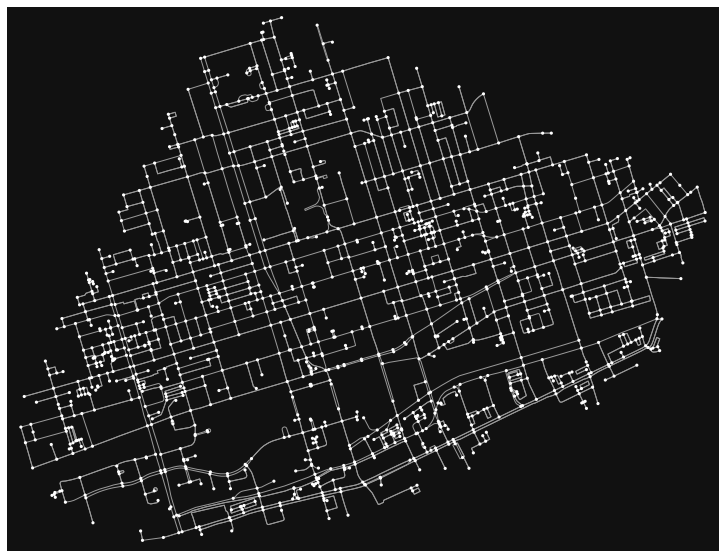

In [8]:
# Display Graph

fig, ax = ox.plot_graph(G, node_size=10, figsize=(16,10))
plt.show()

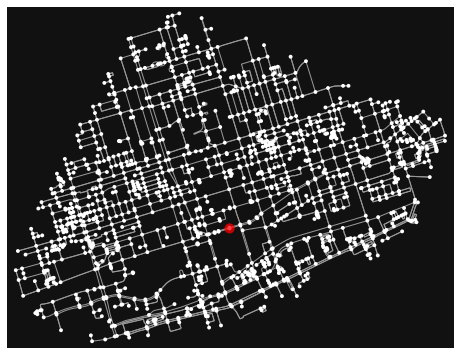

In [9]:
# get nearest node
ox.get_nearest_node(G, (43.645609, -79.380386))

# highlight the nearest node
fig, ax = ox.plot_graph_route(G, [ox.get_nearest_node(G, (43.645609, -79.380386))], figsize=(16,10))
plt.show()

In [10]:
trip_df.loc[trip_df['Start Station Name']=='Union Station'].head(10)

,Trip Id,Start Time,Start Station Id,Start Station Name,Start Station Latitude,Start Station Longitude,Start Station Elevation,Start Station Capacity,Start Station Accepts Credit Card,Start Station FSA,...,End Station Longitude,End Station Elevation,End Station Capacity,End Station Accepts Credit Card,End Station FSA,Trip Duration Minutes,Is Member,Temp (°C),Rel Hum (%),Wind Spd (km/h)
40,712422,2017-01-01 02:47:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.376265,99.0,23.0,1.0,M5J,7,1,1.2,67.0,37.0
41,712423,2017-01-01 02:47:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.376265,99.0,23.0,1.0,M5J,6,1,1.2,67.0,37.0
214,712602,2017-01-01 17:44:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.376800,105.0,31.0,1.0,M5B,9,1,2.2,61.0,18.0
454,712853,2017-01-01 23:13:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.356598,83.0,15.0,1.0,M5A,11,1,0.6,76.0,8.0
521,712922,2017-02-01 00:58:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.338931,80.0,19.0,1.0,M4M,15,1,-2.9,93.0,11.0
529,712930,2017-02-01 01:15:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.398167,103.0,19.0,1.0,M5T,15,1,-2.9,93.0,11.0
570,712971,2017-02-01 05:01:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.390477,96.0,15.0,1.0,M5V,5,1,-0.3,78.0,39.0
607,713010,2017-02-01 11:57:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.380055,102.0,19.0,1.0,M5H,4,1,2.3,64.0,34.0
616,713025,2017-02-01 12:42:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.367139,90.0,19.0,1.0,M5A,8,1,2.9,51.0,35.0
695,713140,2017-02-01 15:06:00,7033,Union Station,43.645609,-79.380386,87.0,42.0,1.0,M5J,...,-79.397735,110.0,17.0,1.0,M5S,12,1,3.0,48.0,26.0


In [11]:
trip_df.iloc[570]

Trip Id                                                  712971
Start Time                                  2017-02-01 05:01:00
Start Station Id                                           7033
Start Station Name                                Union Station
Start Station Latitude                                  43.6456
Start Station Longitude                                -79.3804
Start Station Elevation                                      87
Start Station Capacity                                       42
Start Station Accepts Credit Card                             1
Start Station FSA                                           M5J
End Time                                    2017-02-01 05:05:00
End Station Id                                             7059
End Station Name                     Front St W / Blue Jays Way
End Station Latitude                                    43.6435
End Station Longitude                                  -79.3905
End Station Elevation                   

In [12]:
point_a = ox.get_nearest_node(G, (43.6456, -79.3803))
point_b = ox.get_nearest_node(G, (43.6582, -79.3768))
point_c = ox.get_nearest_node(G, (43.6435, -79.3905))
point_d = ox.get_nearest_node(G, (43.6615, -79.3389))

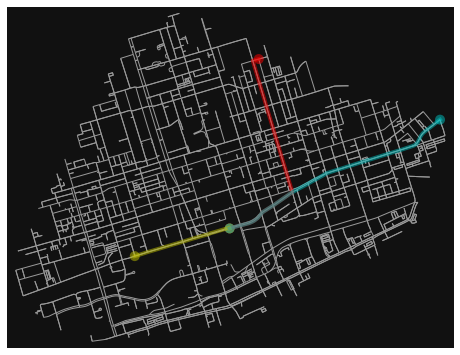

In [13]:
# impute missing edge speeds and calculate free-flow travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# calculate shortest path
route1 = nx.shortest_path(G, point_a, point_b, weight='travel_time')
route2 = nx.shortest_path(G, point_a, point_c, weight='travel_time')
route3 = nx.shortest_path(G, point_a, point_d, weight='travel_time')

# plot routes
routes = [route1, route2, route3]
colors = ['r', 'y', 'c']
fig, ax = ox.plot_graph_routes(G, routes, route_colors=colors, node_size=0, figsize=(16,10))
plt.show()

In [15]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')
print('Route 3 is', route3_length, 'meters and takes', route3_time, 'seconds.')

Route 1 is 1794 meters and takes 151 seconds.
Route 2 is 824 meters and takes 71 seconds.
Route 3 is 1997 meters and takes 171 seconds.
